## Assignment 3
#### Trajectory Optimization and RRT
Hi, we are going to solve a complete robotic manipulation task with cheat perception. The aim of this notebook is to introduce you to the technical background necessary to perform trajectory optimisation on real robots with dynamic models and obstacles in your application scenarios. There is no task to complete, but you should try to understand as many details as possible by playing with the code.

In this notebook we use a popular symbolic optimisation framework names casadi, here is the full docs if you want to check its usage.
https://web.casadi.org/docs/  
Complied with pinocchio as we used in the first assignment, we can generate rigid body kinematics / dynamics models for our 3-link planar robot problem.

In [1]:
import time
import casadi
import pinocchio as pin
import numpy as np
from pinocchio import casadi as cpin
from visualizer import MeshcatVisualizer

Let's import our robot and visualise it in the meshcat interactive renderer.

In [2]:
from pendulum_env import NPendulum
pen = NPendulum(3) # 3 link pendulum
viz = MeshcatVisualizer(model=pen.model, visual_model=pen.geom_model, collision_model=pen.geom_model)

# Display a robot configuration.
q0 = pin.neutral(pen.model)
viz.display(q0)
viz.viewer.jupyter_cell()

/home/jiayun/Desktop/pendulum_env.py:15: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom_base = pin.GeometryObject("base", 0, shape_base, pin.SE3.Identity())
/home/jiayun/Desktop/pendulum_env.py:36: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
/home/jiayun/Desktop/pendulum_env.py:45: UserWarning: This function has been marked as deprecated and will be removed in a future release.
  geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


We can use the pin.aba to call the articulated body algorithm to compute its joint acceleration under a predefined control signal.

In [3]:
dt = 0.01
T = 7

N = int(np.floor(T/dt))

data_sim = pen.model.createData()
geom_data = pin.GeometryData(pen.geom_model)

t = 0.
q = pin.randomConfiguration(pen.model)
v = np.zeros((pen.model.nv))
tau_control = np.zeros((pen.model.nv))
damping_value = 0.1
for k in range(N):

    tic = time.time()
    tau_control = -damping_value * v # small damping
    a = pin.aba(pen.model,data_sim,q,v,tau_control) # Forward dynamics

    # Semi-explicit integration
    v += a*dt
    q = pin.integrate(pen.model,q,v*dt) # Configuration integration

    viz.display(q)
    toc = time.time()
    ellapsed = toc - tic

    dt_sleep = max(0,dt - (ellapsed))
    time.sleep(dt_sleep)
    t += dt

Let's find an interesting initial configuration to continue our planning task.

In [4]:
# q = pin.randomConfiguration(pen.model)
q = np.array([2.81480423, 0.11725295, 2.39162303])
viz.display(q)

Let's generate the model and data container as we did in first assignment.

In [5]:
rmodel = pen.model
rdata = rmodel.createData()
# q = pin.randomConfiguration(rmodel)
# pin.forwardKinematics(rmodel, rdata, q)
# rdata.oMi[3]

In [6]:
# add a red box to indicate the goal postition for end-effector.
boxID = "world/box"
viz.addBox(boxID, [0.05, 0.1, 0.2], [1.0, 0.2, 0.2, 0.5])
# Add a vizualisation for the tip of the arm.
tipID = "world/blue"
viz.addBox(tipID, [0.2] * 3, [0.5, 0.2, 1.0, 0.5])

We generate six black spheres dubbed as obstacles, that we may meet in real life, in the scene to make this problem more meaningful.

In [7]:
from types import SimpleNamespace
ob_radius = 0.125
obstacles = []
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , 0.75]), name=f"obs_1"))
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , 0.]), name=f"obs_2"))
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , 1.]), name=f"obs_3"))
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , 0.25]), name=f"obs_4"))
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , -0.25]), name=f"obs_5"))
obstacles.append(SimpleNamespace(radius=ob_radius, pos=np.array([-0., 1. , 1.25]), name=f"obs_6"))

for io, o in enumerate(obstacles):
    viz.addSphere(f"obs_{io}", o.radius, [0.1, 0.1, 0.1, 0.9])

Let's define the final position our robot.

In [8]:
Mtarget = pin.SE3(pin.utils.rotate("y", 3), np.array([-0., 1.3, 0.5]))  # x,y,z

You can check the frames attached to the robot through the following method. The frame corresponding to our endeffector is ball_3.

In [9]:
for k,frame in enumerate(pen.model.frames):
    print("frame {}: {}".format(k,frame.name))

frame 0: universe
frame 1: joint_1
frame 2: joint_2
frame 3: joint_3
frame 4: ball_3


You can get the frameID of the end-effector like this

In [10]:
endEffector_ID = pen.model.getFrameId("ball3")
endEffector_ID

5

Let's write some helper functions to render the progress of optimisation algorithms.

In [11]:
def displayScene(q, dt=1e-1):
    """
    Given the robot configuration, display:
    - the robot
    - a box representing endEffector_ID
    - a box representing Mtarget
    """
    pin.framesForwardKinematics(rmodel, rdata, q)
    M = rdata.oMf[endEffector_ID-1]
    viz.applyConfiguration(boxID, Mtarget)
    viz.applyConfiguration(tipID, M)

    for io, o in enumerate(obstacles):
        viz.applyConfiguration(f"obs_{io}", pin.SE3(np.eye(3), o.pos))
    viz.display(q)
    time.sleep(dt)

def displayTraj(qs, dt=5e-2):
    for q in qs[1:]:
        displayScene(q, dt=dt)

displayScene(q)

### Part 1: Trajectory optimization with multiple-shooting method and implicit Euler integration.
You should check the class slides to know what does multiple-shooting means.
For implicit Eula integration we could check this wiki: https://en.wikipedia.org/wiki/Backward_Euler_method#:~:text=In%20numerical%20analysis%20and%20scientific,it%20is%20an%20implicit%20method.

We gonna code this optmization problem:
$$\begin{aligned}\min_{x_t,u_t} \sum_{t=1}^{T} &l(x_t,u_t) + L(x_T)\\ &x_{t+1} = f(x_t,t_t)\\ &u_t \in \mathcal{U},\, \forall t=1,...,T\\
&x_t \in \mathcal{X}, \forall t=1,...,T\end{aligned}$$
All the states and control should lay inside admissable region and the evolution of states should follow the physics.

Let's define the discretization interval and total duration of our trajectory.

In [12]:
T = 50
DT = 0.05

We then use pinocchio to generate the dynamic models (symbolic representation as you may check) and declare the dimension of our optimisation problem.

In [13]:
cmodel = cpin.Model(pen.model)
cdata = cmodel.createData()

nq = pen.model.nq # num of joints
nv = pen.model.nv # num of actuators
nx = nq + nv # state space is [q, dq]
ndx = 2 * nv # state differentiation is [dq, ddq]
cx = casadi.SX.sym("x", nx, 1)
cdx = casadi.SX.sym("dx", nv * 2, 1)
cq = cx[:nq]
cv = cx[nq:]
caq = casadi.SX.sym("a", nv, 1) # joint acceleration
ctauq = casadi.SX.sym("tau", nv, 1) # joint torque

# Compute kinematics/dynamics casadi graphs
cpin.aba(cmodel, cdata, cq, cv, ctauq)
cpin.forwardKinematics(cmodel, cdata, cq, cv, caq)
cpin.updateFramePlacements(cmodel, cdata)

The beuty of trajectory optimization is we can handle torque limits explicitly !

In [14]:
effort_limit = casadi.MX(rmodel.effortLimit) # get the torque limit of this robot

Get the forward dynamics model through aba algorithm. This casadi.Function can be called for symbolic input or numpy array.

In [15]:
caba = casadi.Function("aba", [cx, ctauq], [cdata.ddq]) # (name, [input variables], [result])

We implement implicit euler integration also as a casadi function.

In [16]:
cnext = casadi.Function(
    "next",
    [cx, caq],
    [
        casadi.vertcat(
            cpin.integrate(cmodel, cx[:nq], cx[nq:] * DT + caq * DT**2),
            cx[nq:] + caq * DT,
        )
    ],
)

The end-effector position error function:

In [17]:
error_tool = casadi.Function(
    "etool3", [cx], [cdata.oMf[endEffector_ID-1].translation - Mtarget.translation]
)

e_pos function: the method we will use to compute the obstales' position in the endeffector frame!
$$cdata.oMi[3].inverse() = ^{tip}T_{task}$$

In [18]:
cpos = casadi.SX.sym("p", 3)
    # Position of the obstacle cpos in the ellipse frame. You can regard this as a "placeholder".

e_pos = casadi.Function(
    "e_pos", [cq, cpos], [cdata.oMi[3].inverse().act(casadi.SX(cpos))]
)

The decision variable we will use in the optimization problem. You can understand them as some "pytorch" style computational graph building blocks.

In [19]:
opti = casadi.Opti()
var_xs = [opti.variable(nx) for t in range(T + 1)]
var_as = [opti.variable(nv) for t in range(T)]
var_us = [opti.variable(nv) for t in range(T)]

In [20]:
totalcost = 0
# Define the running cost
for t in range(T):
    totalcost += 1e-3 * DT * casadi.sumsqr(var_xs[t][nq:])
    totalcost += 1e-3 * DT * casadi.sumsqr(var_as[t])

    # totalcost += 1e-3 * DT * casadi.sumsqr(var_us[t])   # You may explore how the trajectory can be changed if we use other optimality indicator
totalcost += 1e4 * casadi.sumsqr(error_tool(var_xs[T]))

Define the initial constraints.

In [21]:
opti.subject_to(var_xs[0][:nq] == q)
opti.subject_to(var_xs[0][nq:] == 0)  # zero initial velocity
opti.subject_to(var_xs[T][nq:] == 0)  # zero terminal velocity

Define the dynamic constraints.

In [22]:
for t in range(T):
    opti.subject_to(caba(var_xs[t], var_us[t]) == var_as[t])
    opti.subject_to(cnext(var_xs[t], var_as[t]) == var_xs[t + 1])

The torque limit constraints.

In [23]:
for t in range(T):
    opti.subject_to(var_us[t] <= effort_limit)
    opti.subject_to(var_us[t] >= - effort_limit)

The "ball" attached on the end-effector is defined in the last joint coordinate, with placement [0,0,1], we need the following constant to help us defining obstacle constraints.

In [24]:
body_placement = pin.SE3.Identity().translation
body_placement[2] = 1.

The definition of obstacle constraints. We can check whether the end-effector will incurr collisions along this trajectory.  
With
$$(x-y)^T R(x-y) \leq 1,$$
you can check if a point y is inside of outside of an ellipse locates at x with its contour matrix R. For a sphere, the R is diagonal with each entry as $\frac{1}{r^2}$, where $r$ is its radius.

In [25]:
end_effector_radius = 0.1
obstacle_radius = 0.1
for t in range(T):
    for o in obstacles:
        # obstacle position in ellipsoid (joint) frame
        pos_in_jointF = e_pos(var_xs[t][:nq], o.pos)
        opti.subject_to((pos_in_jointF-body_placement).T @ np.eye(3) * 1/((end_effector_radius+obstacle_radius)**2) @ (pos_in_jointF - body_placement) >= 1.)

Then you are ready to solve this optimization problem, and you can check the result at each iteration through the meshcat renderer!

In [ ]:
opti.minimize(totalcost)
opti.solver("ipopt")  # set numerical backend
opti.callback(lambda i: displayScene(opti.debug.value(var_xs[-1][:nq])))

# Caution: in case the solver does not converge, we are picking the candidate values
# at the last iteration in opti.debug, and they are NO guarantee of what they mean.
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_as = [opti.value(var_a) for var_a in var_as]
    sol_us = [opti.value(var_u) for var_u in var_us]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_as = [opti.debug.value(var_a) for var_a in var_as]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     2559
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:     1356

Total number of variables............................:      606
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      459
Total number of inequality c

As you can see it's quite expensive to get a solution for this kinodynamic planning problem! If you remove the dynamics constraints, the situation can be improved.  
Let's play the final trajectory in the renderer.

In [ ]:
print("***** Display the resulting trajectory ...")
displayScene(q, 1)
displayTraj([x[:nq] for x in sol_xs], DT)

***** Display the resulting trajectory ...


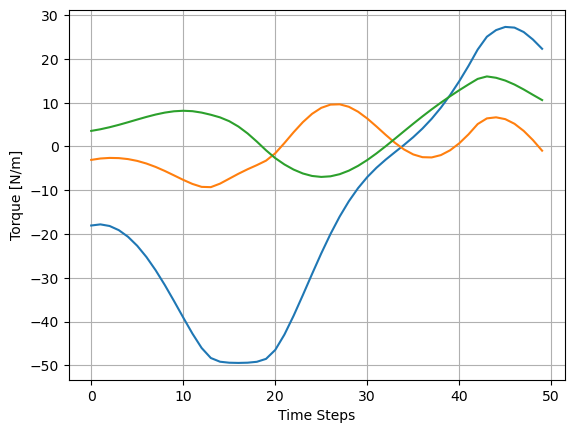

In [ ]:
torques = np.concatenate(sol_us).reshape(-1,3)
import matplotlib.pyplot as plt
plt.plot(torques)
plt.xlabel("Time Steps")
plt.ylabel("Torque [N/m]")
plt.grid()
plt.show()

In [ ]:
rmodel = pen.model
rdata = rmodel.createData()
pin.framesForwardKinematics(rmodel, rdata, q)
pin.updateFramePlacements(rmodel, rdata)
start_x = rdata.oMf[4].translation[1:]
goal_x = Mtarget.translation[1:]

In [ ]:
class Node:
    def __init__(self, value):
        self.value = value
        self.parent = None
# RRT main()
def rrt(start, goal, num_iterations, step_size, upperlim, lowerlim, obstacles=[]):
    nodes = [Node(start)]
    for _ in range(num_iterations):
        rand_point = Node(np.random.uniform(lowerlim, upperlim))
        nearest_node = min(nodes, key=lambda n: float(np.linalg.norm(n.value-rand_point.value)))
        new_node = extend(nearest_node, rand_point, step_size)
        new_node.parent = nearest_node
        if not collides(new_node, obstacles):
            nodes.append(new_node)
            if distance(new_node, goal) < step_size:
                goal_node = Node(goal)
                goal_node.parent = new_node
                nodes.append(goal_node)
                return nodes
        else:
            continue
    return None

def extend(from_node, to_node, step_size):
    normal_vector = to_node.value - from_node.value
    normal_vector /= np.linalg.norm(normal_vector)
    new_value = from_node.value + step_size * normal_vector
    return Node(new_value)

def distance(node, goal):
    return np.linalg.norm(node.value - goal) # You may define other distance metrics

# postprocess procedure to backtrack the tree.
def backtrack(nodes):
    path = []
    current = nodes[-1]
    while current:
        path.insert(0, current.value)
        current = current.parent
    return path

def collides(node, obstacles):
    is_collides = False
    for o in obstacles:
        # obstacle position in ellipsoid (joint) frame
        is_collides = np.linalg.norm(node.value - o.pos[1:]) <= (ob_radius + 0.1)
        if is_collides:
            return is_collides
    return is_collides

Let's try to solve the problem trajectory optimization has done.

In [ ]:
rrt_result = rrt(start_x, goal_x, 2000, 0.15, np.array([3.,3.]), np.array([-3.,-3.]), obstacles)

You can notice the rrt planner is super fast to find a feasible solution, even it's written by python and use no fancy acceleration trick. But definitely not considering the optimality. You can improve it using the tricks introduced in Georgia's class. Let's fetch the path and render it.

In [ ]:
rrt_path = backtrack(rrt_result)

In [ ]:
for i, points in enumerate(rrt_path):
    viz.addSphere(f"path_point_{i}", 0.02, [0.1, 0.9, 0.9, 0.9])
    viz.applyConfiguration(f"path_point_{i}", pin.SE3(np.eye(3), np.concatenate([np.array([0]), points])))
    displayScene(q)

In [ ]:
viz.viewer.jupyter_cell()

Having found a feasible trajectory from start to finish, you can use the inverse kinematics controller introduced in the first problem to generate a smooth trajectory (geometric path with time allocation).
Nowadays, many applications use the solution found by RRT as a warm start of the optimal control problem, which can speed up the solution.
However, you should note that our optimizer is ipopt, so even if you use the exact solution, the optimizer will still need to update the dual variables for several iterations. You can try it with the following command.
Therefore, RRT initialisation is usually less helpful in ipopt.

In [ ]:
# You can use this method to warm start the optimizer, before you call the limited_solve()
opti.set_initial(sol.value_variables())